# Question 1: Dataframe Creation

**Before we get the data and start exploring it, let's download all the dependencies that we will need.**

In [6]:
#importing Libraries
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd

In [7]:
#Getting the data from url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [8]:
#First 5 records
data.head()

,Borough,Neighborhood,Postal code
0,Not assigned,None,M1A
1,Not assigned,None,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Regent Park / Harbourfront,M5A


In [9]:
#Choosing only data where field Borough doesn't have not assigned value
raw_data_selected = data[data['Borough'] != 'Not assigned']

In [11]:
#Grouping Data
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postal code'], as_index=False).agg(','.join)

In [12]:
raw_data_selected.head()

,Borough,Postal code,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,Moore Park / Summerhill East


In [15]:
#Replacing values in Neighbourhood field with Borough where Neighbourhood is not assigned
raw_data_selected['Neighborhood'] = np.where(raw_data_selected['Neighborhood'] == 'None', raw_data_selected['Borough'], raw_data_selected['Neighborhood'])

In [20]:
#Shape of Data
raw_data_selected.shape

(103, 3)

# Question 2: Geographical co-ordinates of each postal code.

**We are using .CSV file.**

In [21]:
geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)

In [22]:
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [25]:
# Renaming the columns
geospatial_data.columns = ['Postal code', 'Latitude', 'Longitude']

In [26]:
geospatial_data.columns

Index(['Postal code', 'Latitude', 'Longitude'], dtype='object')

In [27]:
#Merging dataframes
merged_data = pd.merge(raw_data_selected, geospatial_data, on='Postal code')

In [28]:
merged_data.head()

,Borough,Postal code,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160


# Question 3: Analysis on above generated data.

In [36]:
#importing Libraries
!pip install shapely
from shapely.geometry import Point
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
import seaborn as sns

     |████████████████████████████████| 931kB 8.2MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 18.0MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 32.6MB/s eta 0:00:01


In [37]:
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))

In [38]:
merged_data.head()

,Borough,Postal code,Neighborhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [39]:
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)

In [40]:
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')

In [41]:
gdf.head()

,Borough,Postal code,Neighborhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,Central Toronto,M4R,North Toronto West,43.715383,-79.405678,POINT (43.71538 -79.40568)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,Central Toronto,M4T,Moore Park / Summerhill East,43.689574,-79.383160,POINT (43.68957 -79.38316)


/opt/conda/envs/Python36/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


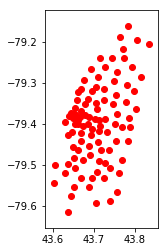

In [42]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black')
# plot and show
gdf.plot(ax=ax, color='red')

plt.show()